<a href="https://colab.research.google.com/github/iammhk/Maximal-Entropy-Random-Walk/blob/master/Node2vec_weighted_node_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Node classification with weighted Node2Vec

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/node-classification/node2vec-weighted-node-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/node-classification/node2vec-weighted-node-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

## Introduction

This notebook illustrates how `Node2Vec` [1] can be applied to learn low dimensional node embeddings of an edge weighted graph through __weighted biased random walks__ over the graph. 

Specifically, the notebook demonstrates:
1. Learning node embeddings using  [Word2Vec](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) algorithm applied to a set of weighted biased random walks performed over a graph.
2. Visualizing the node embeddings in 2-D using the [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) algorithm.
3. Demonstrating how the node embeddings calculated using Word2Vec can be used as feature vectors in a downstream task such as node classification. 
4. Comparing node embeddings learnt from "unweighted Node2Vec" with "weighted Node2Vec" visually as well as in terms of accuracy of node classification task over the same underlying graph. 
5. Lastly, performing a quick check of equivalency of weighted biased random walks to unweighted biased random walks when all edge weights are identically 1.

The example uses components from the `stellargraph`, `Gensim`, and `scikit-learn` libraries.

**Note:** For clarity of exposition, this notebook forgoes the use of standard machine learning practices such as `Node2Vec` parameter tuning, node feature standarization, data splitting that handles class imbalance, classifier selection, and classifier tuning to maximize predictive accuracy. We leave such improvements to the reader.

### References

[1] Node2Vec: Scalable Feature Learning for Networks. A. Grover, J. Leskovec. ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2016. ([link](https://snap.stanford.edu/node2vec/))

[2] Distributed representations of words and phrases and their compositionality. T. Mikolov, I. Sutskever, K. Chen, G. S. Corrado, and J. Dean.  In Advances in Neural Information Processing Systems (NIPS), pp. 3111-3119, 2013. ([link](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf))

[3] Gensim: Topic modelling for humans. ([link](https://radimrehurek.com/gensim/))

[4] scikit-learn: Machine Learning in Python ([link](http://scikit-learn.org/stable/))

In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 17.5 MB/s 
     |████████████████████████████████| 482 kB 22.3 MB/s 
     |████████████████████████████████| 462 kB 65.7 MB/s 
     |████████████████████████████████| 41 kB 240 kB/s 


In [ ]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [ ]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import preprocessing

import numpy as np

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph

from gensim.models import Word2Vec

import warnings 
import collections
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt

%matplotlib inline

### Some global parameters

In [ ]:
walk_length = 100  # maximum length of a random walk to use throughout this notebook

### Dataset

For weighted biased random walks the underlying graph should have weights over the edges. Since the links in the Cora dataset are unweighted, we need to synthetically add weights to the links in the graph. One possibility is to weight each edge by the similarity of its end nodes. Here we assign the Jaccard similarity of the features of the pair of nodes as the weight of edge which we can compute by logical operations on NumPy dataframes of the one-hot encoded features.

In [ ]:
def jaccard_weights(graph, _subjects, edges):
    sources = graph.node_features(edges.source)
    targets = graph.node_features(edges.target)

    intersection = np.logical_and(sources, targets)
    union = np.logical_or(sources, targets)

    return intersection.sum(axis=1) / union.sum(axis=1)

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [ ]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, subjects = dataset.load(
    largest_connected_component_only=True,
    edge_weights=jaccard_weights,
    str_node_ids=True,  # Word2Vec requires strings, not ints
)

In [ ]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 5209

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5209]
        Weights: range=[0, 1], mean=0.0946879, std=0.0918164
        Features: none


Just a quick look at the weights of the edges.

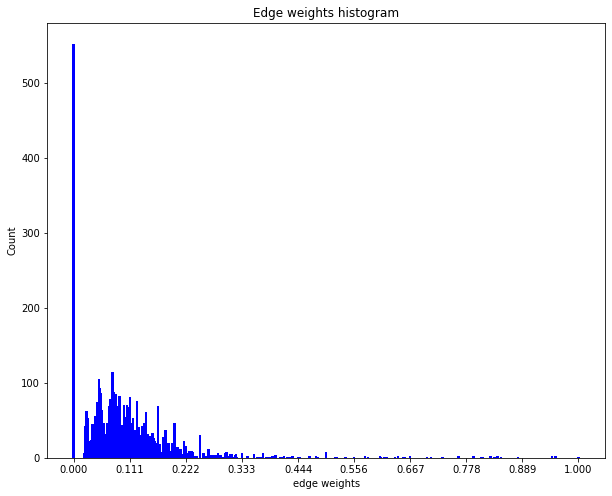

In [ ]:
_, weights = G.edges(include_edge_weight=True)

wt, cnt = np.unique(weights, return_counts=True)

plt.figure(figsize=(10, 8))
plt.bar(wt, cnt, width=0.005, color="b")
plt.title("Edge weights histogram")
plt.ylabel("Count")
plt.xlabel("edge weights")
plt.xticks(np.linspace(0, 1, 10))

plt.show()

The above distribution of edge weights illustrates that majority of linked nodes are insignificantly similar in terms of their attributes.

### The Node2Vec algorithm

The Node2Vec algorithm is a method for learning continuous feature representations for nodes in networks [1]. This approach can simply be described as a mapping of nodes to a low dimensional space of features that maximizes the likelihood of persevering neighborhood structure of the nodes. This approach is not tied to a fixed definition of neighborhood of a node but can be used in conjunction with different notions of node neighborhood, such as, homophily or structural equivalence, among other concepts.  The algorithm efficiently explores diverse neighborhoods of nodes through a biased random walk procedure that is parametrized to emulate a specific concept of the neighborhood of a node. 

Once a predefined number of walks, of fixed lengths, have been sampled, the low dimension embedding vectors of nodes can be learnt using `Word2vec` algorithm [2]. We use the Word2Vec implementation in the free Python library `Gensim` [3] to learn representations for each node in the graph.

## Corpus generation using random walks

The stellargraph library provides an implementation of random walks that can be unweighted or weighted as required by Node2Vec. The random walks have a predefined fixed maximum length and are controlled by three parameters `p`, `q`,  and `weight`. By default, the weight over the edges is assumed to be 1. See [1] for a detailed description of these parameters. 

### Weighted random walks
The first step for the weighted biased random walk is to build a random walk object by passing it a Stellargraph object. 

In [ ]:
rw = BiasedRandomWalk(G)

The next step is to sample a set of random walks of predefined length starting from each node of the graph. Parameters `p`, `q`, and `weighted` influence the type of random walks in the procedure. In this demo, we are going to start 10 random walks from each node in the graph with a length up to 100. We set parameter `p` to 0.5 and `q` to 2.0 and the weight parameter set to True. The `run` method in the random walk will check if the weights over the edges are available and resolve other issues, such as, whether the weights are numeric and that their is no ambiguity of edge traversal (i.e. each pair of node is connected by a unique numerically weighted edge).

In [ ]:
weighted_walks = rw.run(
    nodes=G.nodes(),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=True,  # for weighted random walks
    seed=42,  # random seed fixed for reproducibility
)
print("Number of random walks: {}".format(len(weighted_walks)))

Number of random walks: 24850


In [ ]:
print(weighted_walks[0])

['31336', '31349', '31353', '31349', '31353', '31927', '194617', '31932', '194617', '215912', '31932', '194617', '31927', '31932', '194617', '31927', '194617', '1124844', '194617', '31353', '10531', '31353', '1107567', '31353', '10531', '31353', '31349', '31353', '10531', '31353', '194617', '31353', '1107567', '12165', '1107567', '12165', '1107567', '12238', '1107567', '12238', '1107567', '12238', '12165', '1112099', '12165', '12182', '28641', '12182', '28641', '28640', '28641', '6125', '28641', '6125', '12211', '6125', '1246', '6125', '1246', '6125', '59626', '6125', '59626', '6125', '59626', '6125', '1107572', '6125', '2653', '197783', '2654', '197783', '2653', '65650', '1118764', '65650', '1118764', '2653', '1118764', '65650', '1118764', '65650', '1118764', '65650', '38722', '65650', '309476', '12182', '5038', '65650', '5038', '38722', '5038', '12182', '5038', '65650', '1118764', '2653', '1118764', '2653']


### Representation Learning using Word2Vec

Once we have a sample set of walks, we learn the low-dimensional embedding of nodes using Word2Vec approach.
We set the dimensionality of the learned embedding vectors to 128 as in [1].

In [ ]:
weighted_model = Word2Vec(
    weighted_walks, size=128, window=5, min_count=0, sg=1, workers=1, iter=10
)

In [ ]:
# The embedding vectors can be retrieved from model.wv using the node ID as key.
# E.g., for node id '19231', the embedding vector is retrieved as
emb = weighted_model.wv["19231"]
emb.shape

(128,)

### Visualise Node Embeddings generated by weighted  random walks

We retrieve the `Word2Vec` node embeddings that are 128-dimensional vectors and then we project them down to 2 dimensions using the [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) algorithm for visualization.

In [ ]:
# Retrieve node embeddings and corresponding subjects
node_ids = weighted_model.wv.index2word  # list of node IDs
weighted_node_embeddings = (
    weighted_model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
# the gensim ordering may not match the StellarGraph one, so rearrange
node_targets = subjects.loc[node_ids].astype("category")
print(node_targets.cat.codes)

35         1
6213       4
3231       6
41714      1
10169      6
          ..
62333      2
12275      2
1154233    3
1140548    2
102884     6
Length: 2485, dtype: int8


In [ ]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2, random_state=42)
weighted_node_embeddings_2d = tsne.fit_transform(weighted_node_embeddings)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


### Plot the embeddings generated from weighted random walks

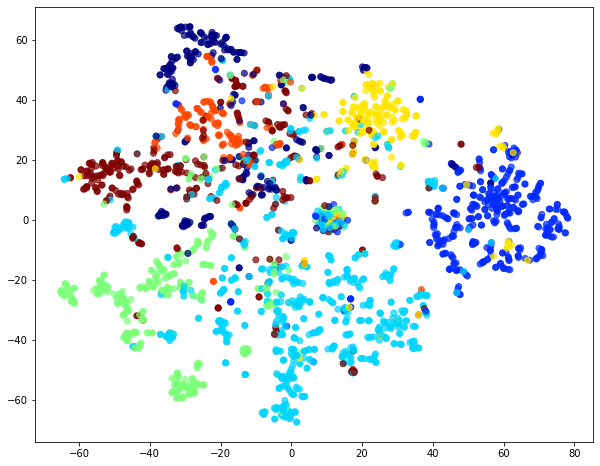

In [ ]:
# draw the points
alpha = 0.7

plt.figure(figsize=(10, 8))
plt.scatter(
    weighted_node_embeddings_2d[:, 0],
    weighted_node_embeddings_2d[:, 1],
    c=node_targets.cat.codes,
    cmap="jet",
    alpha=0.7,
)
plt.show()

### Downstream task

The node embeddings calculated using `Word2Vec` can be used as feature vectors in a downstream task such as node classification. Here we give an example of training a logistic regression classifier using the node embeddings, learnt above, as features.

In [ ]:
# X will hold the 128-dimensional input features
X = weighted_node_embeddings
# y holds the corresponding target values
y = np.array(node_targets)
print(y)

['Genetic_Algorithms' 'Reinforcement_Learning' 'Theory' ...
 'Probabilistic_Methods' 'Neural_Networks' 'Theory']


#### Train and Test split
We use 75% of the data for training and the remaining 25% for testing as a hold out test set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, test_size=None, random_state=42
)
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (1863, 128)
 y_train = (1863,)
 X_test = (622, 128)
 y_test = (622,)


#### Classifier Training

We train a Logistic Regression classifier on the training data. 

In [ ]:
clf = LogisticRegressionCV(
    Cs=10,
    cv=10,
    tol=0.001,
    max_iter=1000,
    scoring="accuracy",
    verbose=False,
    multi_class="ovr",
    random_state=5434,
)
clf.fit(X_train, y_train)

LogisticRegressionCV(cv=10, max_iter=1000, multi_class='ovr', random_state=5434,
                     scoring='accuracy', tol=0.001, verbose=False)

Predict the hold out test set.

In [ ]:
y_pred = clf.predict(X_test)

Calculate the accuracy of the classifier on the test set.

In [ ]:
accuracy_score(y_test, y_pred)

0.7942122186495176

### Comparison to weighted and unweighted biased random walks

Lets compare weighted random walks with unweighted random walks. This simply requires toggling the weight parameter to False in the `run` method of the BiasedRandomWalk. Note, the weight parameter is by default set to False, hence, not specifying the weight parameter would result in the same action. 

#### Step 1: performing unweighted walks

In [ ]:
walks = rw.run(
    nodes=G.nodes(),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=False,  # since we are interested in unweighted walks
    seed=42,  # for reproducibility
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 24850


#### Step 2: learning node embeddings

In [ ]:
model = Word2Vec(walks, size=128, window=5, min_count=0, sg=1, workers=1, iter=1)

#### Plot the embeddings generated from unweighted random walks.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


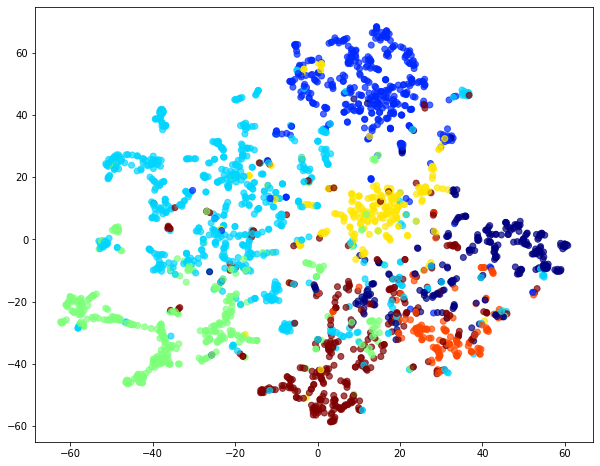

In [ ]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = subjects.loc[node_ids].astype("category")

# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2, random_state=42)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

# draw the points
alpha = 0.7

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_targets.cat.codes,
    cmap="jet",
    alpha=0.7,
)
plt.show()

Visual comparison of node embedding plots for weighted and unweighted random walks illustrates the differences between the two.

#### Using unweighted random walks to train classifiers to predict the subject of a paper in Cora.

In [ ]:
# X will hold the 128-dimensional input features
X = node_embeddings

# y holds the corresponding target values
y = np.array(node_targets)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, test_size=None, random_state=42
)
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (1863, 128)
 y_train = (1863,)
 X_test = (622, 128)
 y_test = (622,)


In [ ]:
clf = LogisticRegressionCV(
    Cs=10,
    cv=10,
    tol=0.01,
    max_iter=1000,
    scoring="accuracy",
    verbose=False,
    multi_class="ovr",
    random_state=5434,
)
clf.fit(X_train, y_train)

LogisticRegressionCV(cv=10, max_iter=1000, multi_class='ovr', random_state=5434,
                     scoring='accuracy', tol=0.01, verbose=False)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.8408360128617364

Generally, the node embeddings extracted from unweighted random walks are more representative of the underlying community structure of the `Cora` dataset than the embeddings learnt from weighted random walks over the artificially weighted Cora network. 

### Testing whether weights = 1 gives identical result to unweighted random walks

Lastly, we perform a quick check of whether weighted biased random walks are identical to unweighted biased random walks when weights over the edges are identically 1. 

First, set weights of all edges in the graph to 1.

In [ ]:
unweighted_G, _ = dataset.load(
    largest_connected_component_only=True,
    edge_weights=None,
    str_node_ids=True,  # Word2Vec requires strings, not ints
)

Quick check to confirm if all edge weights are actually 1.

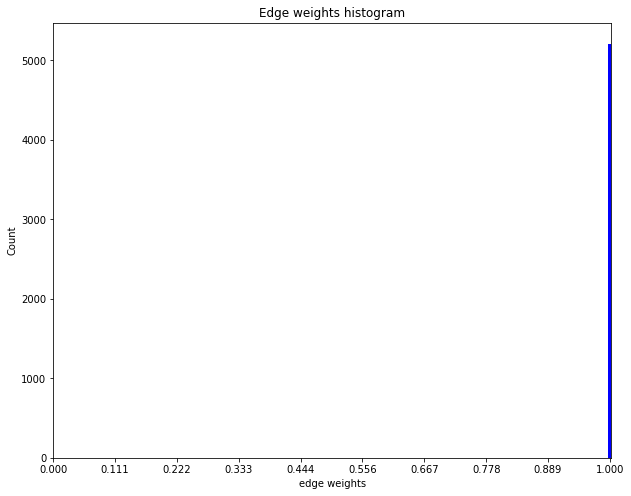

In [ ]:
_, weights = unweighted_G.edges(include_edge_weight=True)

wt, cnt = np.unique(weights, return_counts=True)

plt.figure(figsize=(10, 8))
plt.bar(wt, cnt, width=0.005, color="b")
plt.title("Edge weights histogram")
plt.ylabel("Count")
plt.xlabel("edge weights")
plt.xticks(np.linspace(0, 1, 10))

plt.show()

#### Step 1: create the biased random walk object

In [ ]:
rw = BiasedRandomWalk(unweighted_G)

#### Step 2: sample random walks from the graph.

In [ ]:
weighted_walks = rw.run(
    nodes=unweighted_G.nodes(),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=True,  # indicates the walks are weighted
    seed=42,  # seed fixed for reproducibility
)
print("Number of random walks: {}".format(len(weighted_walks)))

Number of random walks: 24850


Compare unweighted walks with weighted walks when all weights are uniformly set to 1. Note, the two sets should be identical given all other parameters and random seeds are fixed.

In [ ]:
assert walks == weighted_walks

#### Step 3: learn node embeddings from the walks sampled above.

In [ ]:
weighted_model = Word2Vec(
    weighted_walks, size=128, window=5, min_count=0, sg=1, workers=1, iter=10
)

#### Plot the embeddings in 2-D using t-SNE transformation for visual comparison to the embeddings learnt from unweighted walks.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


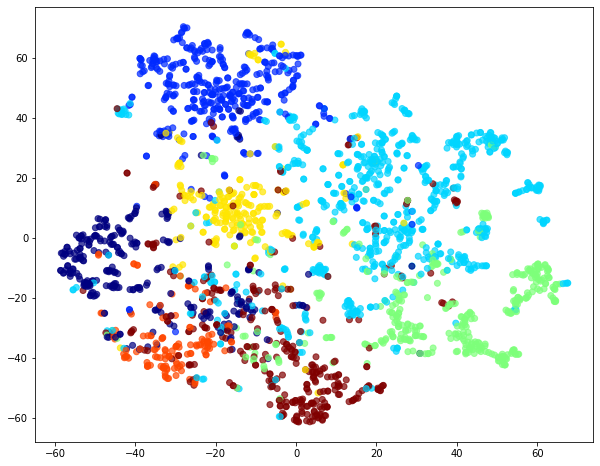

In [ ]:
# Retrieve node embeddings and corresponding subjects
node_ids = weighted_model.wv.index2word  # list of node IDs
weighted_node_embeddings = (
    weighted_model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality

# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2, random_state=42)
weighted_node_embeddings_2d = tsne.fit_transform(weighted_node_embeddings)

# draw the points
alpha = 0.7

plt.figure(figsize=(10, 8))
plt.scatter(
    weighted_node_embeddings_2d[:, 0],
    weighted_node_embeddings_2d[:, 1],
    c=node_targets.cat.codes,
    cmap="jet",
    alpha=0.7,
)
plt.show()

#### Comparing the accuracy of node classification for weighted (weight ==1) and unweighted random walks.

Compare classification of nodes through logistic regression on embeddings learnt from weighted (weight == 1) walks to that of unweighted walks demonstrated above. 

In [ ]:
# X will hold the 128-dimensional input features
X = weighted_node_embeddings

# y holds the corresponding target values
y = np.array(node_targets)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, test_size=None, random_state=42
)
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (1863, 128)
 y_train = (1863,)
 X_test = (622, 128)
 y_test = (622,)


In [ ]:
clf = LogisticRegressionCV(
    Cs=10,
    cv=10,
    tol=0.001,
    max_iter=1000,
    scoring="accuracy",
    verbose=False,
    multi_class="ovr",
    random_state=5434,
)
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegressionCV(cv=10, max_iter=1000, multi_class='ovr', random_state=5434,
                     scoring='accuracy', tol=0.001, verbose=False)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.819935691318328

In [ ]:
np.array_equal(weighted_node_embeddings, node_embeddings)

False

The weighted random walks with weight == 1 are identical to unweighted random walks. Moreover, the embeddings learnt over the two kinds of walks are identical as well.

## Conclusion: 

The above demo of application of Node2Vec method on the CORA dataset using weighted biased random walks demonstrates, weighted biased random walks produce inherently different node embeddings from the embeddings learnt through unweighted random walks over the same graph, as illustrated by t-SNE visualization of the two as well as comparison of performance over node classification.  These differences illustrate that (realistic) weights on the edges of a graph can be leveraged to learn more accurate representation of nodes in low dimensional feature space.

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/node-classification/node2vec-weighted-node-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/node-classification/node2vec-weighted-node-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>